In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt
N=4



In [3]:
def merge_pulses(indices,times,window,energies,thresh):
    pulses=dict()
    times=np.array(list(map(float,times)))
    energies=np.array(list(map(float,energies)))
    indices=np.array(list(map(int,indices)))
    
    
    for i in range(N):
        pulses[i]=np.column_stack((times[indices==i], energies[indices==i]))
        pulses[i]=pulses[i][pulses[i][:,0].argsort()]

    
    for key in pulses.keys():
        temp_time=np.array([])
        temp_energy=np.array([])
        det_pulses=pulses[key]
        for i in range(det_pulses.shape[0]):
            if i==0:
                temp_time=np.append(temp_time,det_pulses[0,0])
                temp_energy=np.append(temp_energy,det_pulses[0,1])
            elif (det_pulses[i,0]-temp_time[-1])>window:
                temp_time=np.append(temp_time,det_pulses[i,0])
                temp_energy=np.append(temp_energy,det_pulses[i,1])
            else:
                temp_energy[-1]+=det_pulses[i,1]
        t_e_mat=np.column_stack((temp_time, temp_energy))
        pulses[key]=t_e_mat[t_e_mat[:,1]>thresh]
        
        """
        print(pulses[key])
        print("-----")
    print("-@@-@@-@@-@@-@@-")"""
    return pulses




In [5]:
data_path = "/Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/Python/BoxSi/proto2.2/Geant4Simulations/YuvalSimulationResults/my_simulations/"

In [6]:
c_names=["Time Gamma","Energy Gamma", "Id Gamma","Time Neutron","Energy Neutron","Id Neutron"]
df = pd.read_csv(data_path+'rossi_nt_rossi.csv',sep=',',   header=9, names=c_names)

energy_threshold=[0.4,2.6] #Energy Threshold for Gamma detection and for Neutron Detection in MeV
window=2e-9 #Time Window. The code merges each pair of pulses that the separtion in time between them is smaller than this value
mass = 1e-9 #grams
rate_fission=3.092*1e-2*19.85e12 *mass#rate of fission events per second
rate = 19.85e12*mass
t_global=0;
particles_names=["Gamma","Neutron"]
det_id=[]
final_pulses_times=np.array([])
final_pulses_energy=np.array([])
final_pulses_id=np.array([])
final_pulses_isN=np.array([])
final_pulses_real_times=np.array([])
eff = 21668/1000000

for i in range(df.shape[0]):
    if (i%10000==0):
        print(i)
    while np.random.rand(1)[0]>eff:
        t_global+=np.random.exponential(1/rate)
    t_global+=np.random.exponential(1/rate)
    
    for particle_i in range(0,2):
        particle_name=particles_names[particle_i]
        row=df.iloc[i]
        time=row["Time "+particle_name]
        if isinstance(time,str):
            energy=row["Energy "+particle_name].split(";")
            det_index=row["Id "+particle_name].split(";")
            time=row["Time "+particle_name].split(";")
            final_pulses=merge_pulses(det_index,time,window,energy,energy_threshold[particle_i])
            
            for key, item in final_pulses.items():
                if (item.size>0):
                    time_row=item[:,0]+t_global
                    final_pulses_times=np.concatenate([final_pulses_times,time_row])
                    final_pulses_real_times=np.concatenate([final_pulses_real_times,item[:,0]])
                    final_pulses_energy=np.concatenate([final_pulses_energy,item[:,1]])
                    final_pulses_id=np.concatenate([final_pulses_id,key*np.ones(time_row.size)])
                    final_pulses_isN=np.concatenate([final_pulses_isN,(particle_name=="Neutron")*np.ones(time_row.size)])




0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


Text(0.5, 0, 'Prompt Energy (MeV)')

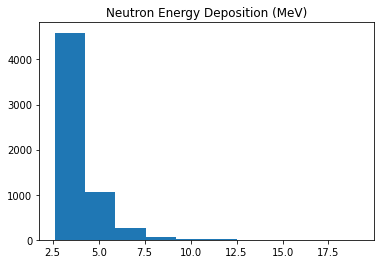

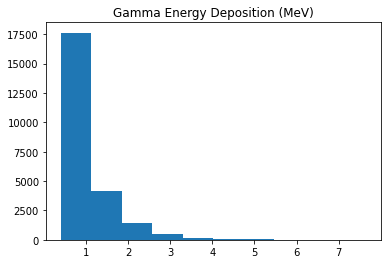

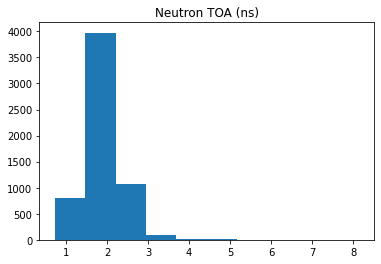

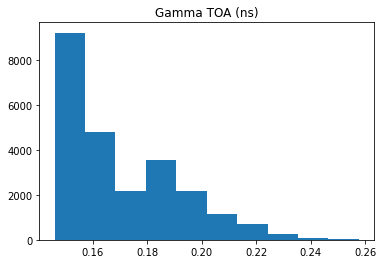

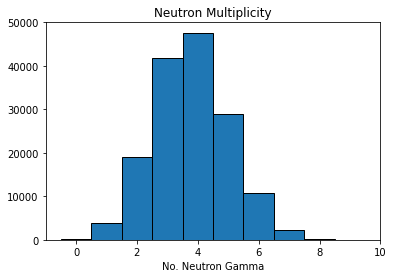

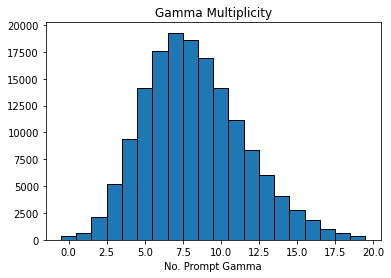

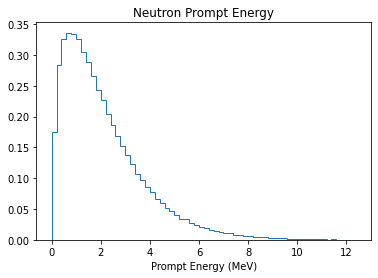

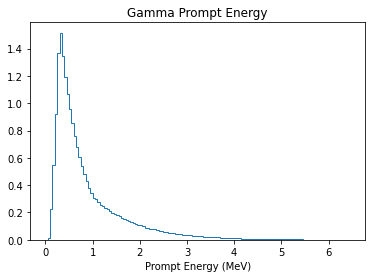

In [7]:
final_pulses_times=final_pulses_times*1e9 #to ns
final_pulses_real_times=final_pulses_real_times*1e9 

titles=["Time (ns)","Energy(MeV)","Detector ID", "IsNeutron"]
df_final=pd.DataFrame(np.column_stack((final_pulses_times,final_pulses_energy,final_pulses_id,final_pulses_isN)),columns=titles)
df_final=df_final.sort_values(by="Time (ns)")
df_final.to_csv(data_path + "pulse_train.csv")

plt.figure()
plt.hist(final_pulses_energy[final_pulses_isN==1])
plt.title("Neutron Energy Deposition (MeV)")

plt.figure()
plt.hist(final_pulses_energy[final_pulses_isN==0])
plt.title("Gamma Energy Deposition (MeV)")

plt.figure()
plt.hist(final_pulses_real_times[final_pulses_isN==1])
plt.title("Neutron TOA (ns)")

plt.figure()
plt.hist(final_pulses_real_times[final_pulses_isN==0])
plt.title("Gamma TOA (ns)")

plt.figure()
df_temp = pd.read_csv(data_path + 'rossi_nt_Neutron Mul.csv',sep=',',   header=4,names=["M"])
plt.hist(df_temp["M"],bins=np.arange(-1,10)+0.5,ec="k")
plt.title("Neutron Multiplicity")
plt.xlabel("No. Neutron Gamma")

plt.figure()
df_temp = pd.read_csv(data_path + 'rossi_nt_Gamma Mul.csv',sep=',',   header=4,names=["M"])
plt.hist(df_temp["M"],bins=np.arange(-1,20)+0.5,ec="k")
plt.title("Gamma Multiplicity")
plt.xlabel("No. Prompt Gamma")

plt.figure()
df_temp = pd.read_csv(data_path + 'rossi_nt_Neutron E.csv',sep=',',   header=4,names=["E"])
plt.hist(df_temp["E"],bins=np.arange(0,12.5,0.2),density=True,histtype=u'step')
plt.title("Neutron Prompt Energy")
plt.xlabel("Prompt Energy (MeV)")

plt.figure()
df_temp = pd.read_csv(data_path + 'rossi_nt_Gamma E.csv',sep=',',   header=4,names=["E"])
plt.hist(df_temp["E"],bins=np.arange(0,6.5,0.05),density=True,histtype=u'step')
plt.title("Gamma Prompt Energy")
plt.xlabel("Prompt Energy (MeV)")






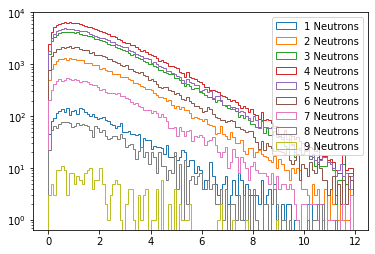

In [10]:

df_temp = pd.read_csv(data_path + 'rossi_nt_Neutron Occ.csv',sep=',',   header=5,names=["ID","E"])
d=dict()
for i in range(1,10):
    d[i]=[]
for event_id in set(df_temp["ID"]):
    d[np.sum(df_temp["ID"]==event_id)]+=list(df_temp["E"][df_temp["ID"]==event_id])
plt.figure()

for key,values in d.items():
    #print(values)
    plt.hist(values, bins=np.arange(0,12,0.1),histtype=u'step',label = "{} Neutrons".format(key))
    plt.legend()
    plt.yscale('log')
plt.show()

